# Nanopore data

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

### Indlæs data

In [51]:
data = pd.read_csv("data_values.tsv", sep="\t")

In [52]:
# Dictionary til at gemme behandlede data
data_dict = {}

# Funktion til at behandle signaler
def process_signal(group):
    """Udtrækker signal, adapter, polya og RNA fra en gruppe"""
    # Konverter "signal" kolonnen til en liste af ints
    group["signal"] = group["signal"].apply(lambda x: np.array([int(i) for i in x.split(",")]))
    
    # Brug kun første række i hver gruppe
    row = group.iloc[0]
    
    signal_subset = row["signal"][:10000]  # Første 10.000 målinger
    polya_start = int(row["polya_start"])
    polya_end = int(row["polya_end"])

    adapter = signal_subset[:polya_start]
    polya = signal_subset[polya_start:polya_end]
    rna = signal_subset[polya_end:]

    return {"adapter": adapter, "polya": polya, "rna": rna}

# Behandl data for hver "read_name"
for read_name, group in data.groupby("read_name"):
    data_dict[read_name] = process_signal(group)

### Plot af alle data

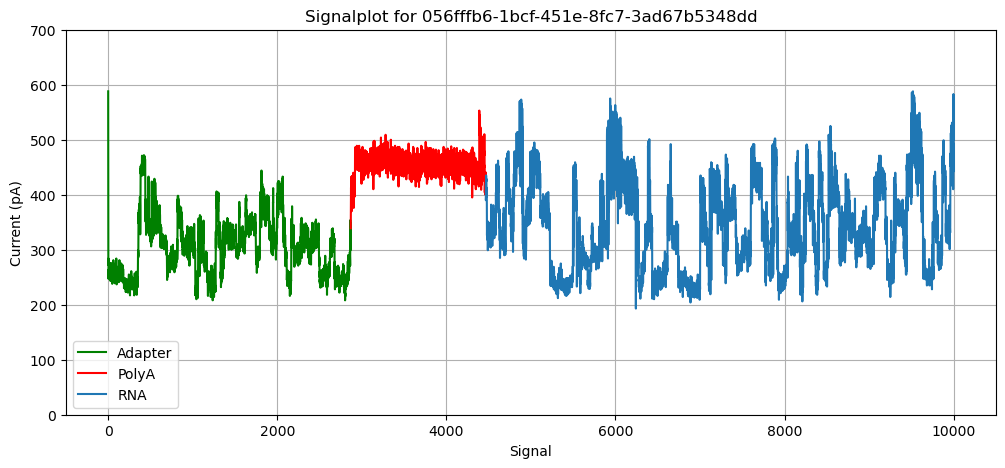

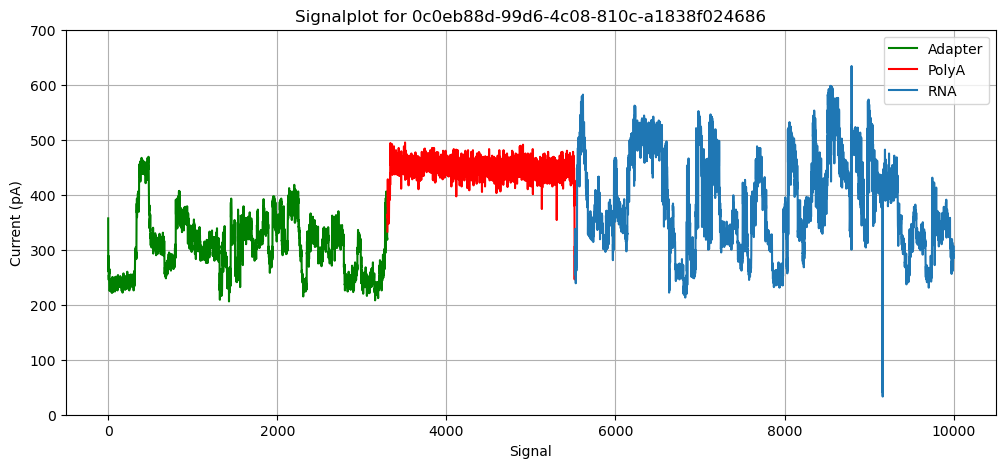

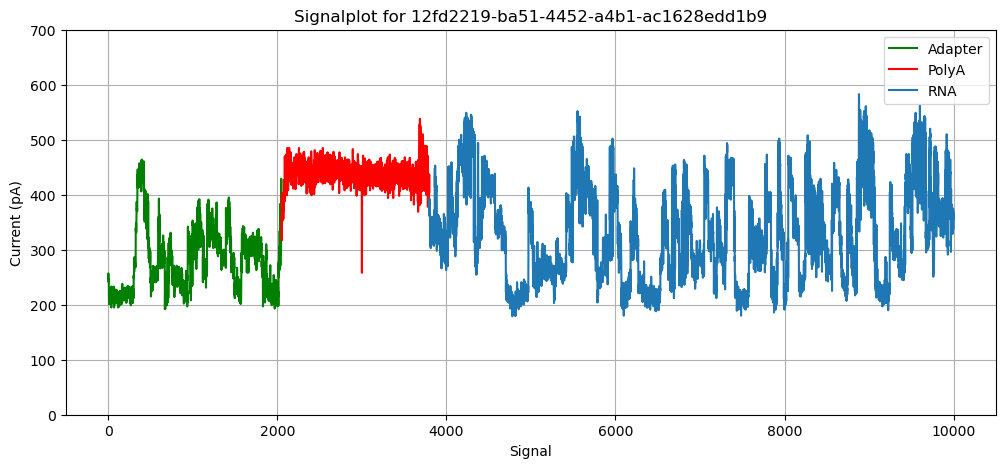

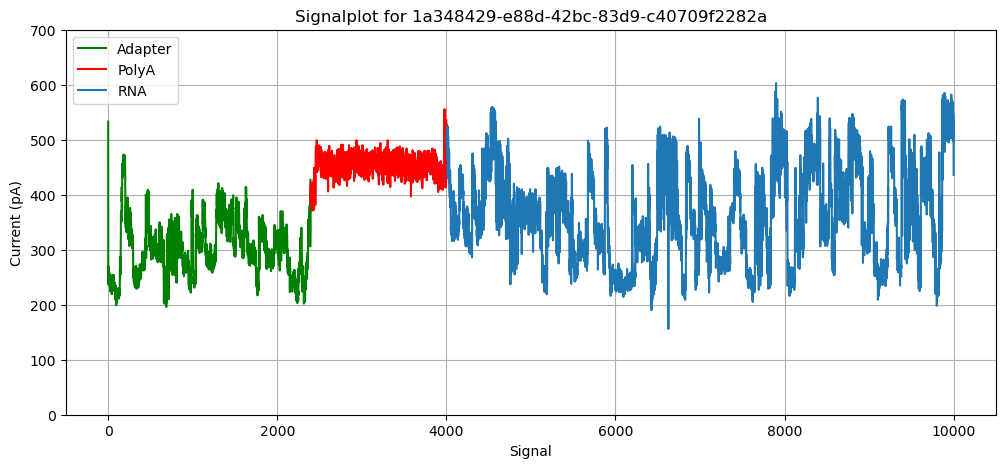

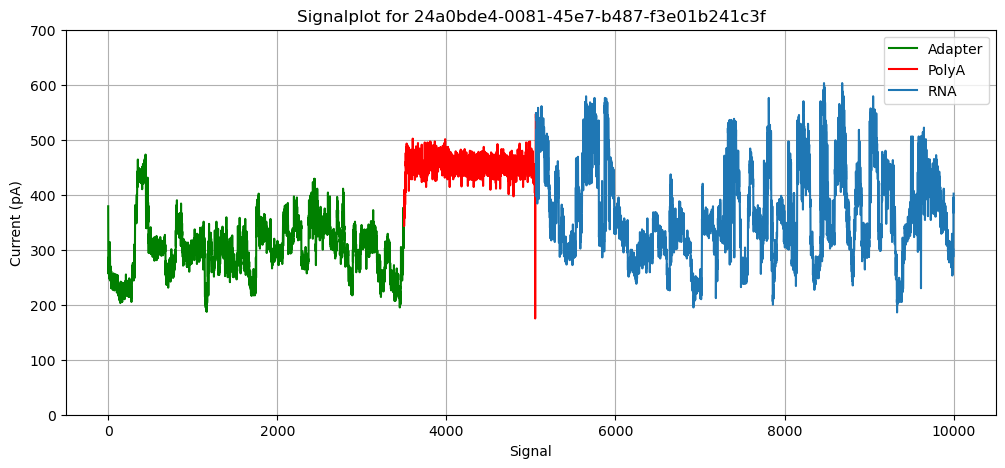

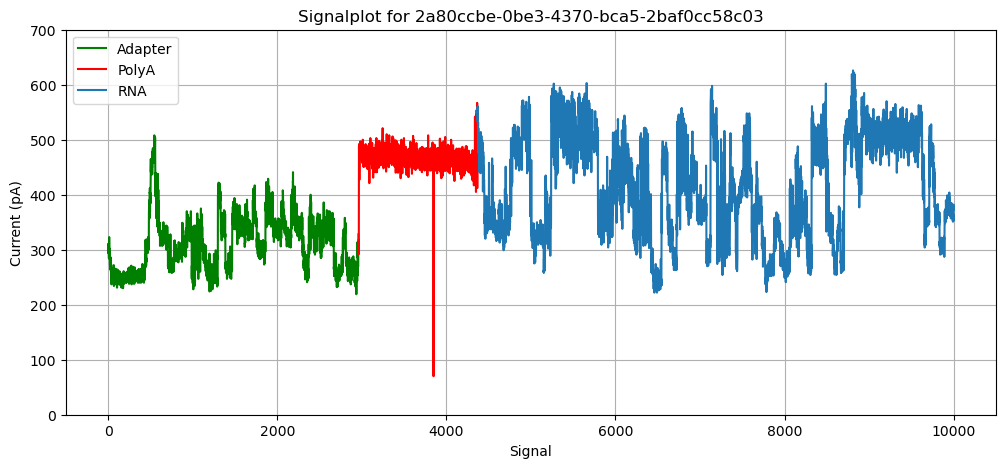

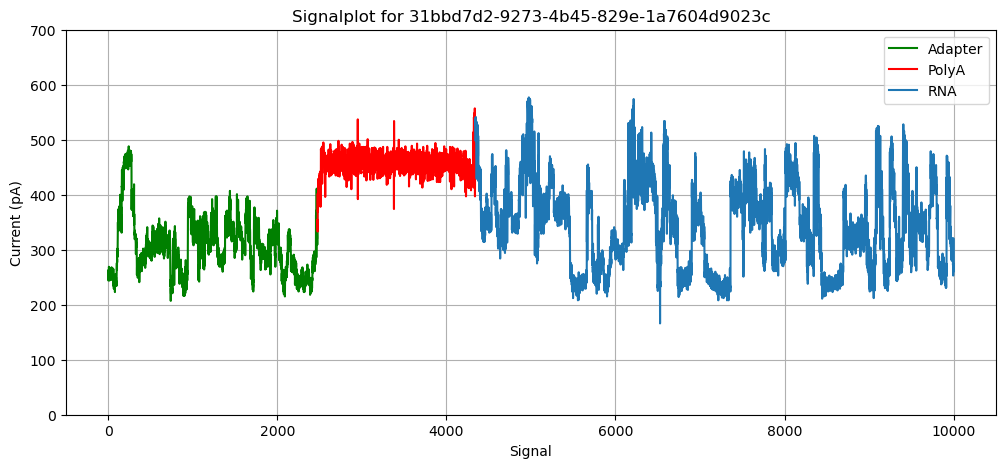

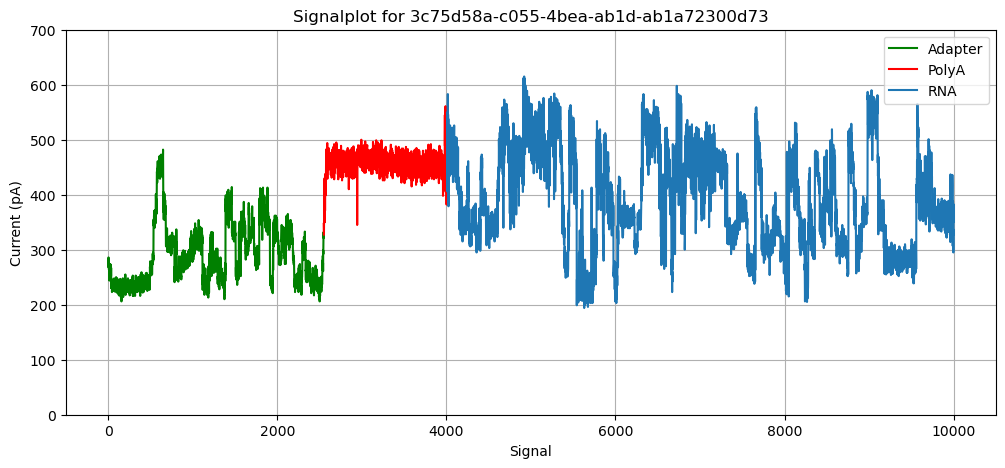

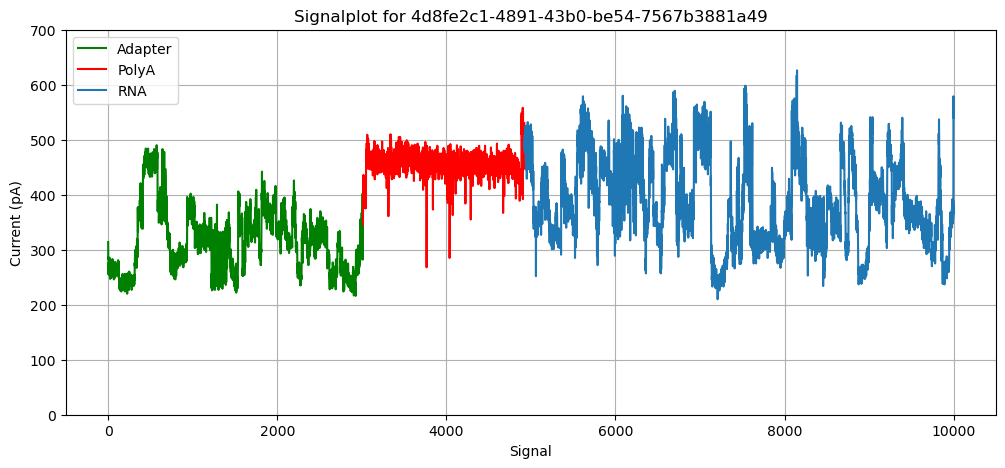

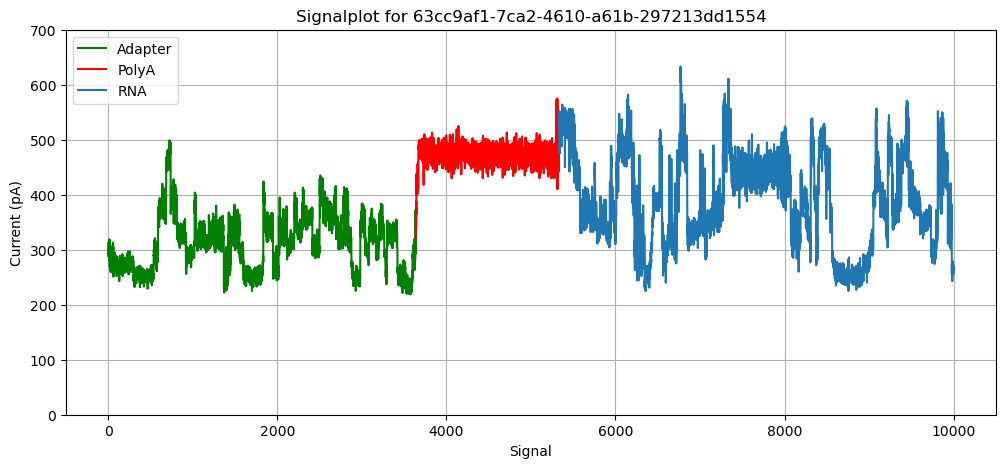

In [53]:
for read_name, signals in data_dict.items():
    plt.figure(figsize=(12, 5))

    adapter, polya, rna = signals["adapter"], signals["polya"], signals["rna"]

    # Plot Adapter
    plt.plot(range(len(adapter)), adapter, color="green", label="Adapter")

    # Plot PolyA
    plt.plot(range(len(adapter), len(adapter) + len(polya)), polya, color="red", label="PolyA")

    # Plot RNA
    plt.plot(range(len(adapter) + len(polya), len(adapter) + len(polya) + len(rna)), rna, label="RNA")

    plt.ylim(0, 700)
    plt.xlabel("Signal")
    plt.ylabel("Current (pA)")
    plt.title(f"Signalplot for {read_name}")
    plt.legend()
    plt.grid()
    plt.show()

### Trimming af adaptere, så de alle starter når current er over en max_start værdi

##### Forsøg med at slette første punkt, hvis det er højere end 350 og lave startpunktet så det er når grafen overstiger er lig med eller større end 350

Trimmer de første 357 værdier af


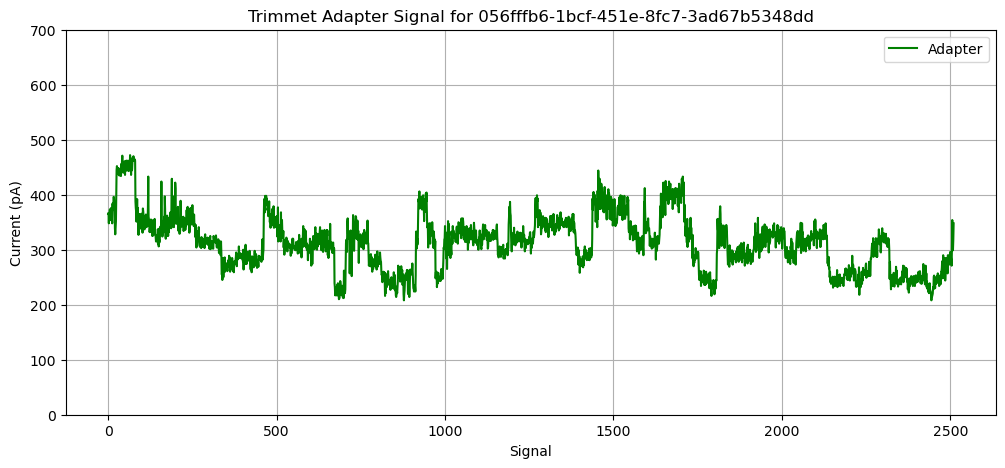

Trimmer de første 334 værdier af


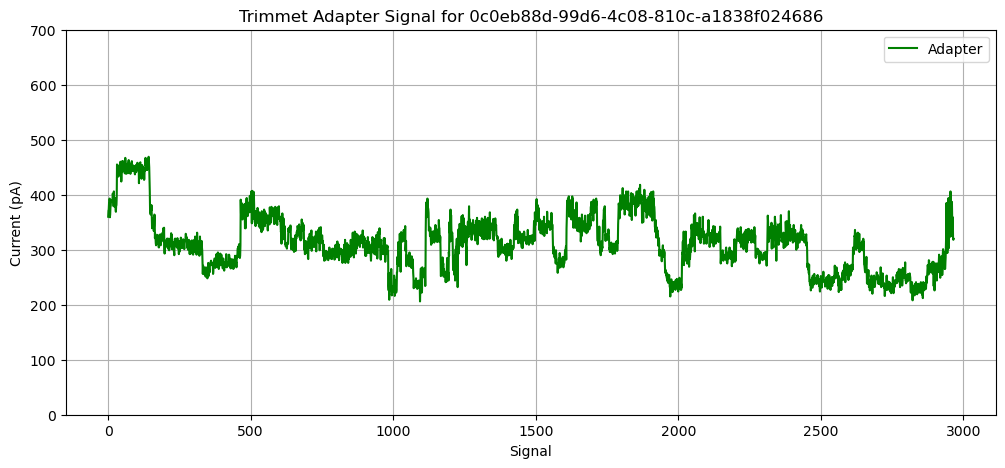

Trimmer de første 335 værdier af


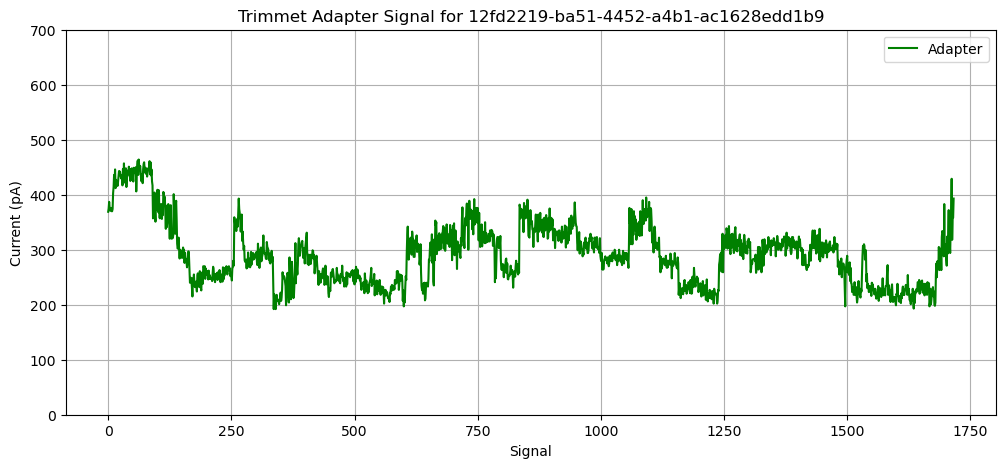

Trimmer de første 150 værdier af


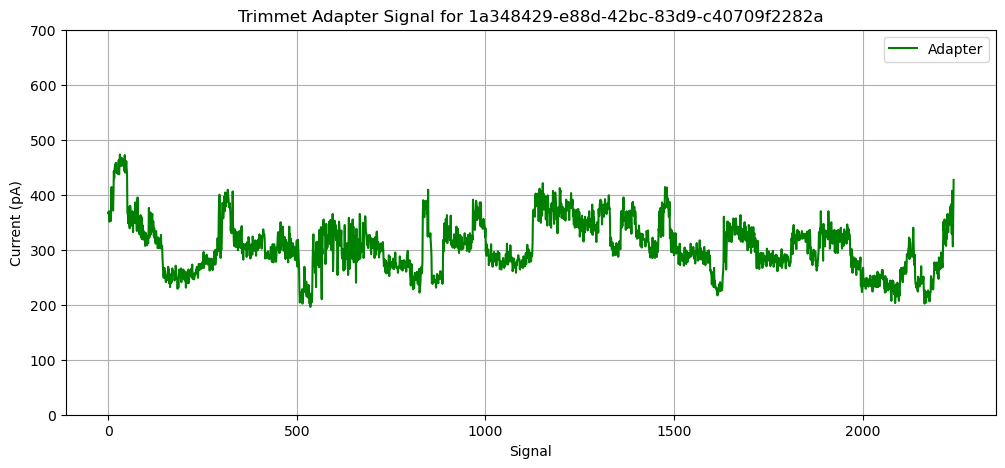

Trimmer de første 317 værdier af


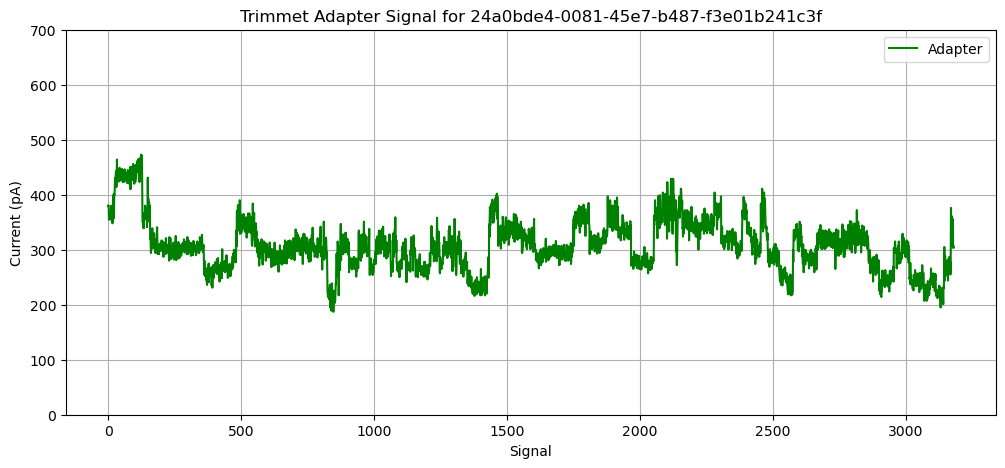

Trimmer de første 481 værdier af


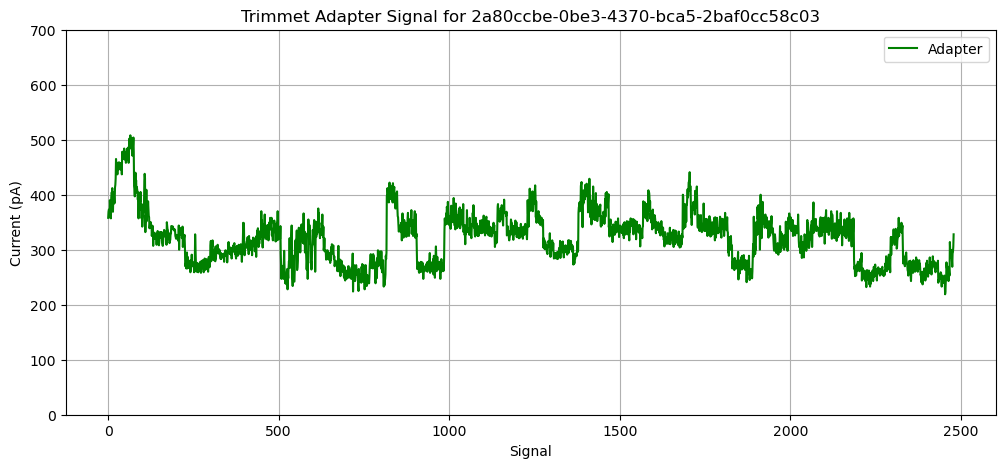

Trimmer de første 115 værdier af


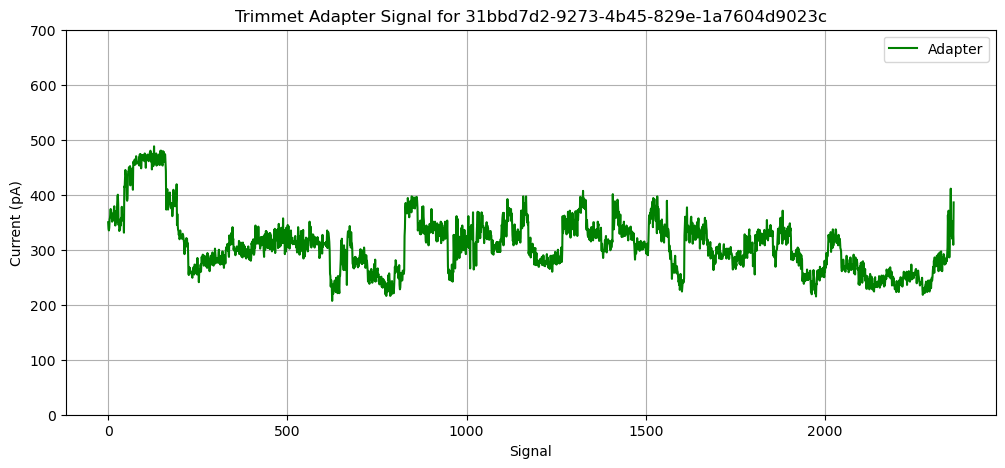

Trimmer de første 537 værdier af


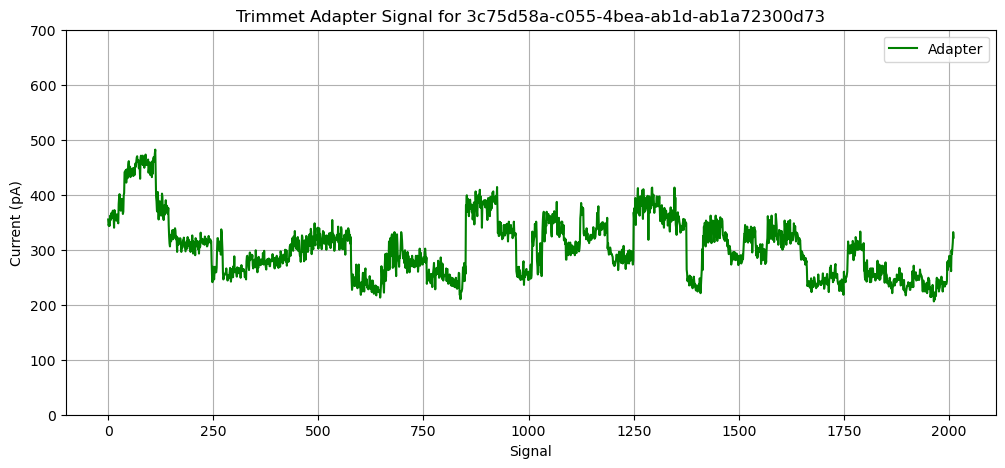

Trimmer de første 349 værdier af


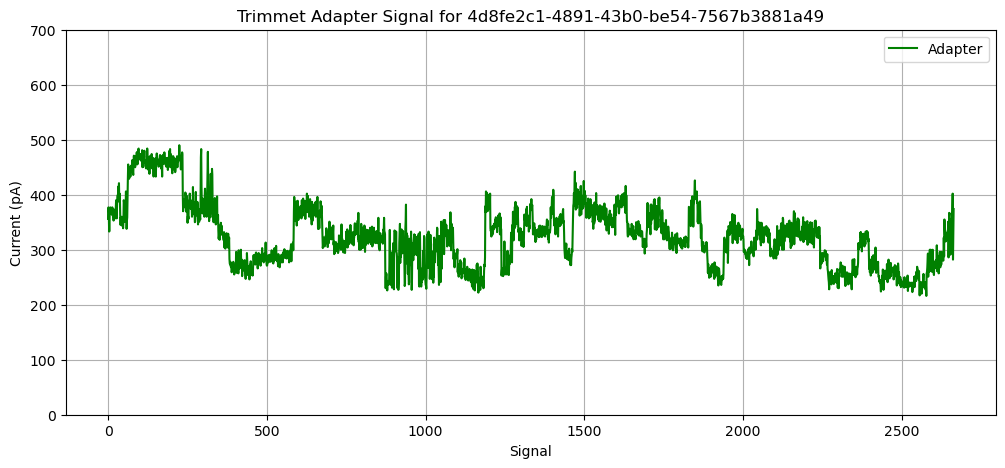

Trimmer de første 590 værdier af


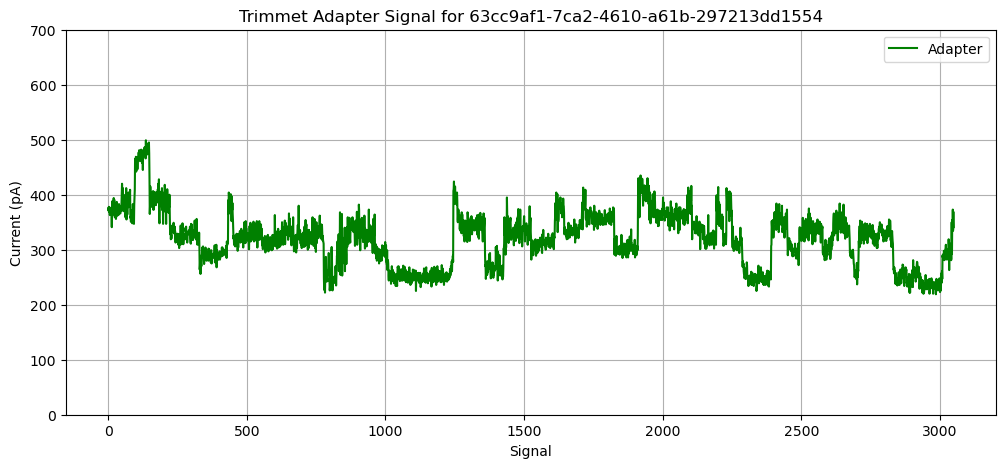

In [54]:
max_start = 350 # Grænseværdi

def trim_signal(signal, max_start):
    """Fjerner første værdi, hvis den er >= max_start og trimmer signalet ved at fjerne værdier indtil den første værdi >= max_start"""
    for i in signal:
        if i >= max_start:
            if signal[0] == i:
                signal = np.delete(signal, 0) # Fjerner første element, hvis det er >= max_start
            else:
                n = np.where(signal == i)[0][0] # Finder index af første værdi >= max_start
                print(f"Trimmer de første {n} værdier af")
                signal = signal[n:] # Trimmer signalet
                break
    return signal

# Trim alle adapter-signaler
for read_name, signals in data_dict.items():
    signals["adapter"] = trim_signal(signals["adapter"], max_start)

    # Plot trimmet adapter signal
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(signals["adapter"])), signals["adapter"], color="green", label="Adapter")

    plt.ylim(0, 700)
    plt.xlabel("Signal")
    plt.ylabel("Current (pA)")
    plt.title(f"Trimmet Adapter Signal for {read_name}")
    plt.legend()
    plt.grid()
    plt.show()   

##### Plot alle trimmede adaptere i samme plot

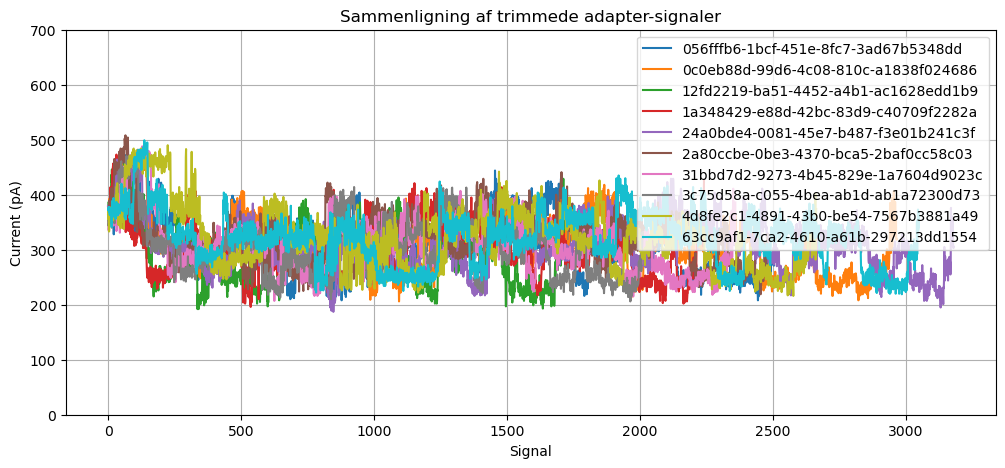

In [55]:
# Opret figur til samlet plot
plt.figure(figsize=(12, 5))

for read_name, signals in data_dict.items():
    plt.plot(range(len(signals["adapter"])), signals["adapter"], label=read_name)  

plt.ylim(0, 700)
plt.xlabel("Signal")
plt.ylabel("Current (pA)")
plt.title("Sammenligning af trimmede adapter-signaler")
plt.legend()
plt.grid()
plt.show()

#### To adapteren plottet sammen

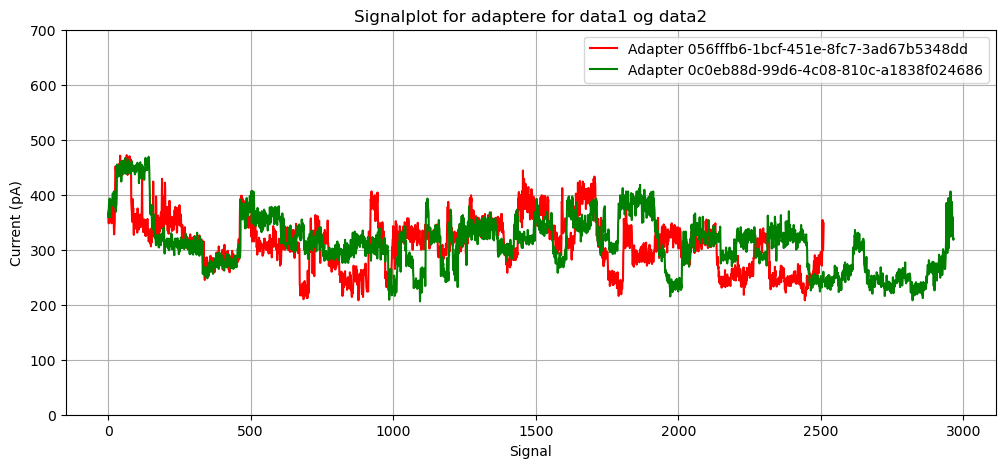

In [56]:
# Vælg to forskellige read_names (vælg første og anden nøgle i data_dict)
read_names = list(data_dict.keys())[:2]  # De to første reads
data1, data2 = data_dict[read_names[0]], data_dict[read_names[1]]

plt.figure(figsize=(12, 5))

plt.plot(range(len(data1["adapter"])), data1["adapter"], color="red", label=f"Adapter {read_names[0]}")

plt.plot(range(len(data2["adapter"])), data2["adapter"], color="green", label=f"Adapter {read_names[1]}")

plt.ylim(0, 700)

plt.xlabel("Signal")
plt.ylabel("Current (pA)")
plt.title("Signalplot for adaptere for data1 og data2")
plt.legend()
plt.grid()
plt.show()

##### Strækning af det lange adapter signal til samme længde som det korte

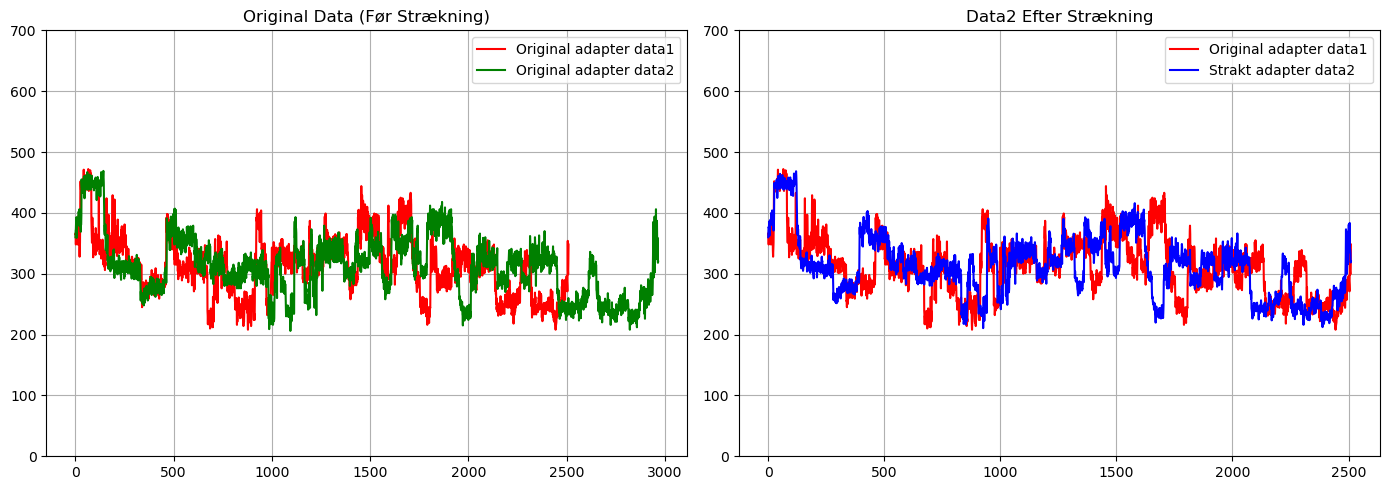

In [57]:
# Definér en skaleringsprocent (f.eks. 50% for at gøre signalet 1.5x længere)
scale_factor = len(data1["adapter"]) / len(data2["adapter"]) 

# Oprindelige længder
ny_len_data2_adapter = int(len(data2["adapter"]) * scale_factor)  # Ny længde efter skalering

# Skab nye x-akse punkter til interpolation
x_original_data2_adapter = np.linspace(0, 1, len(data2["adapter"]))
x_ny_data2_adapter = np.linspace(0, 1, ny_len_data2_adapter)

# Interpolér dataene til den nye længde
data2_adapter_stretched = np.interp(x_ny_data2_adapter, x_original_data2_adapter, data2["adapter"])

# Plot original vs. strakt signal
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Før strækning
axes[0].plot(range(len(data1["adapter"])), data1["adapter"], color="red", label="Original adapter data1")
axes[0].plot(range(len(data2["adapter"])), data2["adapter"], color="green", label="Original adapter data2")
axes[0].set_title("Original Data (Før Strækning)")
axes[0].set_ylim(0, 700)
axes[0].legend()
axes[0].grid()

# Før strækning
axes[1].plot(range(len(data1["adapter"])), data1["adapter"], color="red", label="Original adapter data1")
axes[1].plot(data2_adapter_stretched, color="blue", label="Strakt adapter data2")
axes[1].set_title("Data2 Efter Strækning")
axes[1].set_ylim(0, 700)
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

##### Strækning af det korte adapter signal til samme længde som det lange

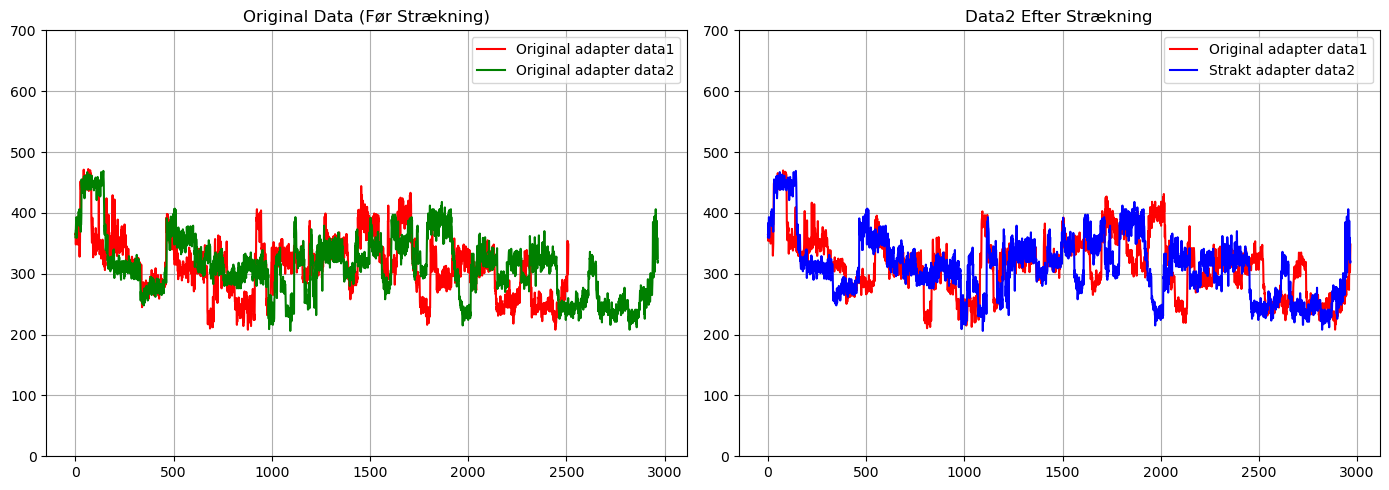

In [58]:
# Definér en skaleringsprocent (f.eks. 50% for at gøre signalet 1.5x længere)
scale_factor = len(data2["adapter"]) / len(data1["adapter"]) 

# Oprindelige længder
ny_len_data1_adapter = int(len(data1["adapter"]) * scale_factor)  # Ny længde efter skalering

# Skab nye x-akse punkter til interpolation
x_original_data1_adapter = np.linspace(0, 1, len(data1["adapter"]))
x_ny_data1_adapter = np.linspace(0, 1, ny_len_data1_adapter)

# Interpolér dataene til den nye længde
data1_adapter_stretched = np.interp(x_ny_data1_adapter, x_original_data1_adapter, data1["adapter"])

# Plot original vs. strakt signal
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Før strækning
axes[0].plot(range(len(data1["adapter"])), data1["adapter"], color="red", label="Original adapter data1")
axes[0].plot(range(len(data2["adapter"])), data2["adapter"], color="green", label="Original adapter data2")
axes[0].set_title("Original Data (Før Strækning)")
axes[0].set_ylim(0, 700)
axes[0].legend()
axes[0].grid()

# Før strækning
axes[1].plot(data1_adapter_stretched, color="red", label="Original adapter data1")
axes[1].plot(range(len(data2["adapter"])), data2["adapter"], color="blue", label="Strakt adapter data2")
axes[1].set_title("Data2 Efter Strækning")
axes[1].set_ylim(0, 700)
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

### Adapter + polyA-hale

##### Stræk det lange (adapter + polyA-hale) signal til at passe længden på det korte

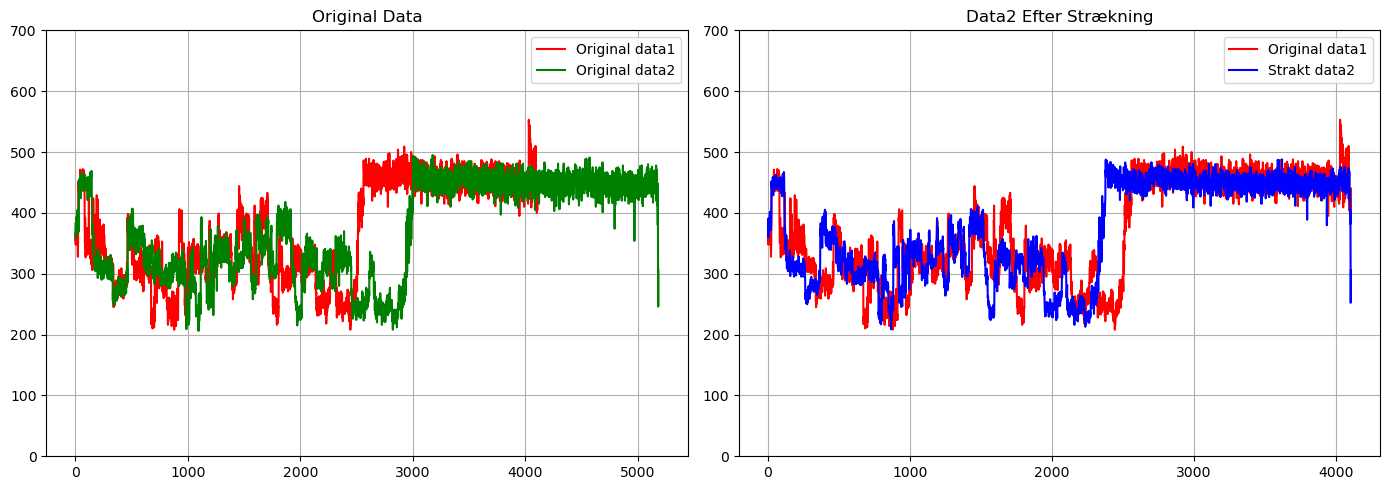

In [59]:
# Kombinere adapter og polya fra data
data1_adapter_polya = np.concatenate((data1["adapter"], data1["polya"]))
data2_adapter_polya = np.concatenate((data2["adapter"], data2["polya"]))

# Strækningen
scale_factor = len(data1_adapter_polya) / len(data2_adapter_polya)

# Skab nye x-akse punkter til interpolation
ny_len_data2 = int(len(data2_adapter_polya) * scale_factor)
x_original_data2 = np.linspace(0, 1, len(data2_adapter_polya))  
x_ny_data2 = np.linspace(0, 1, ny_len_data2)  

# Interpolér dataene til den nye længde
data2_stretched = np.interp(x_ny_data2, x_original_data2, data2_adapter_polya)

# Plot resultaterne
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Før strækning
axes[0].plot(range(len(data1_adapter_polya)), data1_adapter_polya, color="red", label="Original data1")
axes[0].plot(range(len(data2_adapter_polya)), data2_adapter_polya, color="green", label="Original data2")
axes[0].set_title("Original Data")
axes[0].set_ylim(0, 700)
axes[0].legend()
axes[0].grid()

# Efter strækning (ingen forskydning)
axes[1].plot(range(len(data1_adapter_polya)), data1_adapter_polya, color="red", label="Original data1")
axes[1].plot(range(ny_len_data2), data2_stretched, color="blue", label="Strakt data2")
axes[1].set_title("Data2 Efter Strækning")
axes[1].set_ylim(0, 700)
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

##### Stræk de korte (adapter + polyA-hale) signaler til at passe længden på det lange (alle kombinationer af data)

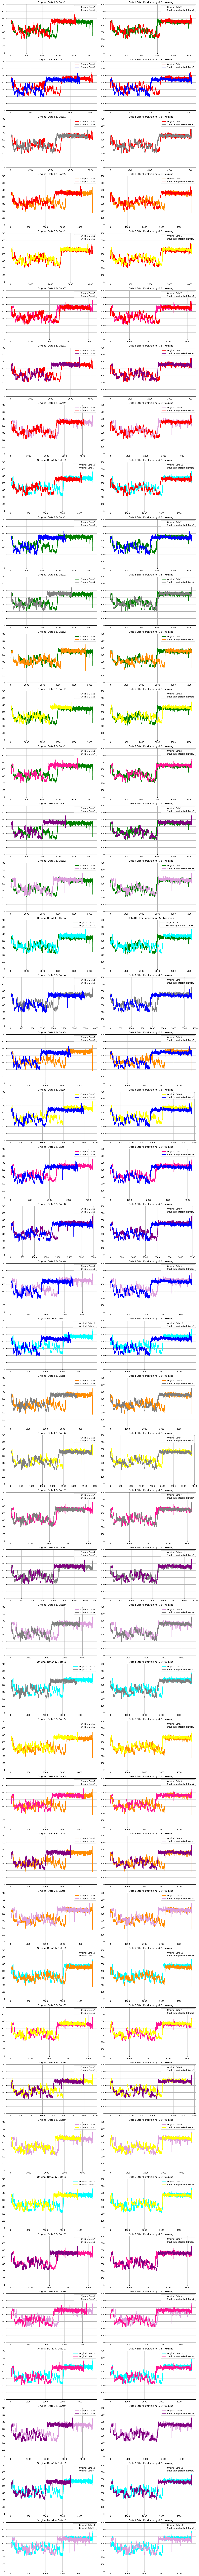

In [64]:
import itertools

read_names = list(data_dict.keys())  # Alle reads
data1, data2, data3, data4, data5, data6, data7, data8, data9, data10 = data_dict[read_names[0]], data_dict[read_names[1]], data_dict[read_names[2]], data_dict[read_names[3]], data_dict[read_names[4]], data_dict[read_names[5]], data_dict[read_names[6]], data_dict[read_names[7]], data_dict[read_names[8]], data_dict[read_names[9]]

data1_adapter_polya = np.concatenate((data1["adapter"], data1["polya"]))
data2_adapter_polya = np.concatenate((data2["adapter"], data2["polya"]))
data3_adapter_polya = np.concatenate((data3["adapter"], data3["polya"]))
data4_adapter_polya = np.concatenate((data4["adapter"], data4["polya"]))
data5_adapter_polya = np.concatenate((data5["adapter"], data5["polya"]))
data6_adapter_polya = np.concatenate((data6["adapter"], data6["polya"]))
data7_adapter_polya = np.concatenate((data7["adapter"], data7["polya"]))
data8_adapter_polya = np.concatenate((data8["adapter"], data8["polya"]))
data9_adapter_polya = np.concatenate((data9["adapter"], data9["polya"]))
data10_adapter_polya = np.concatenate((data10["adapter"], data10["polya"]))

# Opret en liste med dine datasæt og farver
data_list = [
    (data1_adapter_polya, "red", "Data1"),
    (data2_adapter_polya, "green", "Data2"),
    (data3_adapter_polya, "blue", "Data3"),
    (data4_adapter_polya, "grey", "Data4"),
    (data5_adapter_polya, "darkorange", "Data5"),
    (data6_adapter_polya, "yellow", "Data6"),
    (data7_adapter_polya, "deeppink", "Data7"),
    (data8_adapter_polya, "purple", "Data8"),
    (data9_adapter_polya, "plum", "Data9"),
    (data10_adapter_polya, "cyan", "Data10")
]

# Find alle kombinationer af subsets
combinations = list(itertools.combinations(data_list, 2))

# Opret subplots med nok rækker til at vise alle par
fig, axes = plt.subplots(len(combinations), 2, figsize=(14, len(combinations) * 4))

# Loop igennem alle kombinationer og stræk data
for idx, ((dataa, colora, labela), (datab, colorb, labelb)) in enumerate(combinations):
    # Strækningen
    short_data = dataa if len(dataa) < len(datab) else datab
    long_data = datab if len(dataa) < len(datab) else dataa

    scale_factor = len(long_data) / len(short_data)

    short_label = labela if len(dataa) < len(datab) else labelb
    long_label = labelb if len(dataa) < len(datab) else labela

    short_color = colora if len(dataa) < len(datab) else colorb
    long_color = colorb if len(dataa) < len(datab) else colora

    # Skub signalet til højre
    shifted_x = np.arange(len(short_data)) #+ x_shift  

    # Skab nye x-akse punkter til interpolation
    ny_len_short_data = int(len(short_data) * scale_factor)
    x_original_short_data = np.linspace(0, 1, len(short_data))  
    x_ny_short_data = np.linspace(0, 1, ny_len_short_data)  

    # Interpolér dataene til den nye længde (lineær interpolation)
    short_data_stretched = np.interp(x_ny_short_data, x_original_short_data, short_data)

    # Justér forskydning, så slutpunkterne er ens
    slutpunkt_long_data = len(long_data)
    slutpunkt_short_data = ny_len_short_data # x_shift + 
    x_offset = slutpunkt_long_data - slutpunkt_short_data 

    # Skab ny x-akse med forskydning, så slutpunktet matcher
    shifted_x_stretched = np.linspace(x_offset, slutpunkt_long_data, ny_len_short_data) # x_shift + 

    # Før forskydning
    axes[idx, 0].plot(range(len(long_data)), long_data, color=long_color, label=f"Original {long_label}")
    axes[idx, 0].plot(range(len(short_data)), short_data, color=short_color, label=f"Original {short_label}")
    axes[idx, 0].set_title(f"Original {short_label} & {long_label}")
    axes[idx, 0].set_ylim(0, 700)
    axes[idx, 0].legend()
    axes[idx, 0].grid()

    # Efter både skubning og strækning
    axes[idx, 1].plot(range(len(long_data)), long_data, color=long_color, label=f"Original {long_label}")
    axes[idx, 1].plot(shifted_x_stretched, short_data_stretched, color=short_color, label=f"Strukket og forskudt {short_label}")
    axes[idx, 1].set_title(f"{short_label} Efter Forskydning & Strækning")
    axes[idx, 1].set_ylim(0, 700)
    axes[idx, 1].legend()
    axes[idx, 1].grid()

# Justér layout for at undgå overlap
plt.tight_layout()
plt.show()

##### Stræk de korte (adapter + polyA-hale) signaler til at passe længden på det længste signal

Data med det længste signal er data: Data2


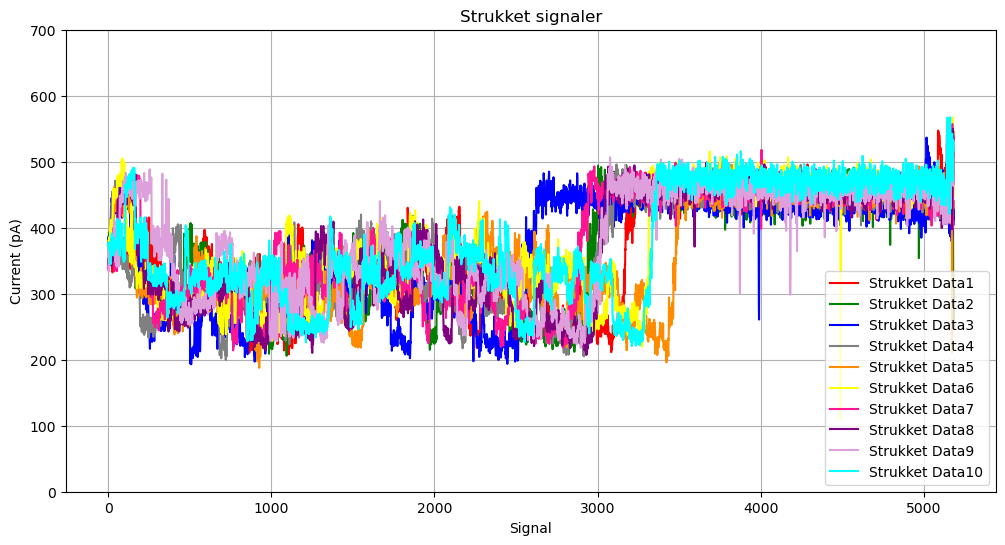

In [77]:
# Startværdier til at finde det længste datasæt
longest_data = None
longest_data_length = 0
longest_label = ""
longest_color = ""

# Find det længste datasæt
for data, color, label in data_list:
    if len(data) > longest_data_length:
        longest_data = data
        longest_data_length = len(longest_data)
        longest_label = label
        longest_color = color

print(f"Data med det længste signal er data: {longest_label}")

plt.figure(figsize=(12, 6))

# Loop igennem alle datasæt og interpolér de kortere
for data, color, label in data_list:
    # Strækningen
    short_data_length = min(longest_data_length, len(data))

    # Beregn skaleringsfaktoren for at matche longest_data_length
    scale_factor = longest_data_length / short_data_length

    short_data = data if short_data_length < longest_data_length else longest_data
    short_label = label if short_data_length < longest_data_length else longest_label
    short_color = color if short_data_length < longest_data_length else longest_color

    # Skab nye x-akse punkter til interpolation
    ny_len_short_data = int(len(short_data) * scale_factor)
    x_original_short_data = np.linspace(0, 1, len(short_data))  
    x_ny_short_data = np.linspace(0, 1, ny_len_short_data)  

    # Interpolér dataene til den nye længde (lineær interpolation)
    data_stretched = np.interp(x_ny_short_data, x_original_short_data, short_data)

    plt.plot(data_stretched, color=short_color, label=f"Strukket {short_label}")

# Plotopsætning
plt.title("Strukket signaler")
plt.xlabel("Signal")
plt.ylabel("Current (pA)")
plt.ylim(0, 700)
plt.legend()
plt.grid()

plt.show()

På plottet oven over er alle datasæt strukket og forskudt, så de passer på data2

##### Gennemsnit af de strukkede signaler

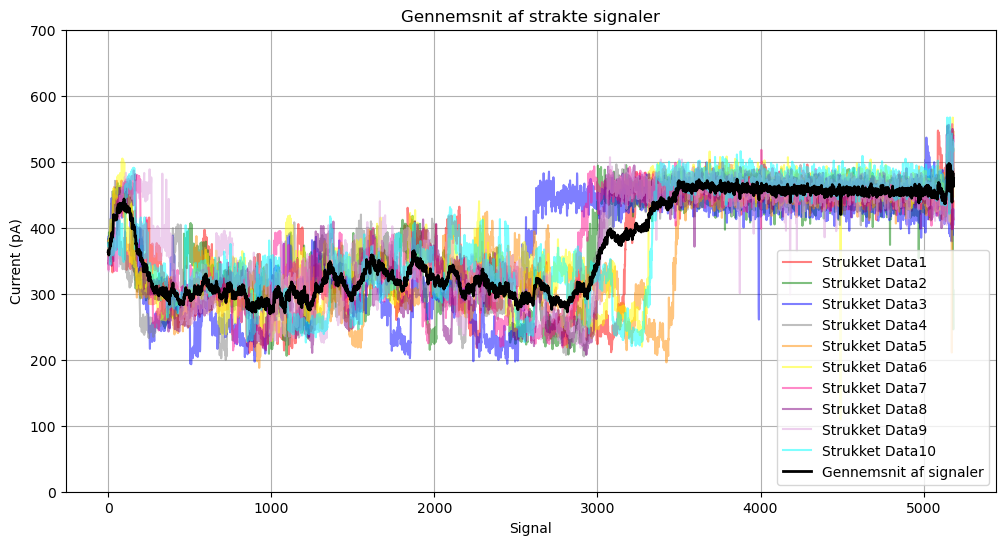

In [78]:
# Startværdier til at finde det længste datasæt
longest_data = None
longest_data_length = 0
longest_label = ""
longest_color = ""

# Find det længste datasæt
for data, color, label in data_list:
    if len(data) > longest_data_length:
        longest_data = data
        longest_data_length = len(longest_data)
        longest_label = label
        longest_color = color

plt.figure(figsize=(12, 6))

# Liste til at lagre de interpolerede signaler
stretched_signals = []

# Loop igennem alle datasæt og interpolér de kortere
for data, color, label in data_list:
    # Strækningen
    short_data_length = min(longest_data_length, len(data))

    # Beregn skaleringsfaktoren for at matche longest_data_length
    scale_factor = longest_data_length / short_data_length

    short_data = data if short_data_length < longest_data_length else longest_data
    short_label = label if short_data_length < longest_data_length else longest_label
    short_color = color if short_data_length < longest_data_length else longest_color

    # Skab nye x-akse punkter til interpolation
    ny_len_short_data = int(len(short_data) * scale_factor)
    x_original_short_data = np.linspace(0, 1, len(short_data))  
    x_ny_short_data = np.linspace(0, 1, ny_len_short_data)  

    # Interpolér dataene til den nye længde (lineær interpolation)
    data_stretched = np.interp(x_ny_short_data, x_original_short_data, short_data)

    # Gem de strakte signaler
    stretched_signals.append(data_stretched)

    plt.plot(data_stretched, color=short_color, alpha=0.5, label=f"Strukket {short_label}")


# Find den maksimale længde blandt de interpolerede signaler
max_length = max(len(sig) for sig in stretched_signals)

# Ensart længder ved padding
stretched_signals = np.array([
    np.pad(sig, (0, max_length - len(sig)), mode='constant', constant_values=np.nan) 
    for sig in stretched_signals
])

# Beregn gennemsnittet (ignorerer NaN-værdier)
average_signal = np.nanmean(stretched_signals, axis=0)

# Opret x-akse for gennemsnittet
x_average = np.linspace(0, len(longest_data), len(average_signal))

# Plot gennemsnittet af alle signaler
plt.plot(x_average, average_signal, color='black', linewidth=2, label="Gennemsnit af signaler")

# Plotopsætning
plt.title("Gennemsnit af strakte signaler")
plt.xlabel("Signal")
plt.ylabel("Current (pA)")
plt.ylim(0, 700)
plt.legend()
plt.grid()
plt.show()